In [1]:
import torch
import numpy as np

import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from dynamics import*
from utils import*
from _4DVar import*

# Load data

In [2]:
root_dir='../data/generated/'
i=0

initial_condition=np.load(root_dir+'initial_conditions/'+
                          '{0:04}'.format(int(i))+'.npy')
Obs=np.load(root_dir+'Obs/'
                          +'{0:04}'.format(int(i))+'.npy')

Rm1=torch.ones(Obs.shape)*(Obs!=0)

# Plot

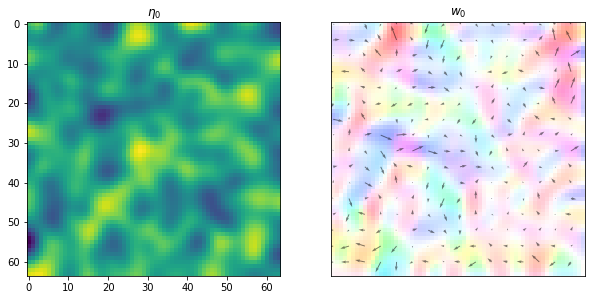

In [15]:
# Ground truth initial conditions
eta0_truth=initial_condition[0,:,:]
w0_truth=torch.Tensor(initial_condition[1:,:,:])

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(eta0_truth)
plt.title('$\eta_{0}$')
plt.subplot(1,2,2)
plot_w(w0_truth[0,:,:], w0_truth[1,:,:], quiver=True, title='$w_{0}$', q_scale=2.5)
plt.show()

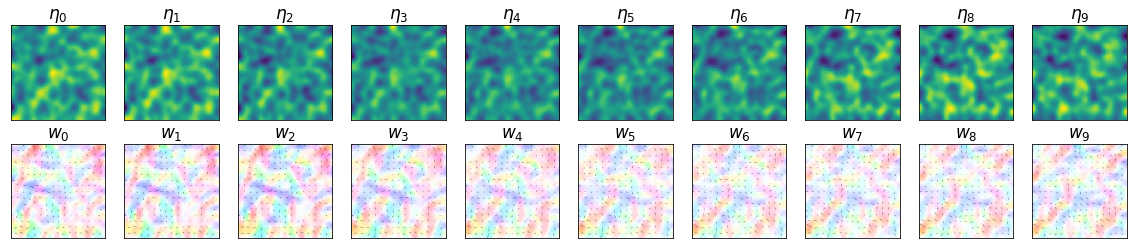

In [12]:
# Trajectory
T=10
X = torch.Tensor(initial_condition)
dynamics=SW(dx,dy)
plt.figure(figsize=(20,4))
for t in range(T):
        
    plt.subplot(2,T,t+1)
    plt.title('$\eta_{'+str(t)+'}$',fontsize=17)
    plt.yticks([])
    plt.xticks([])

    plt.imshow(X[0,:,:])
    plt.subplot(2,T,T+t+1)
    plot_w(X[1,:,:],X[2,:,:],quiver=True,title='w_'+str(t),q_scale=2.5)
    plt.title('$w_{'+str(t)+'}$',fontsize=17)
    
    X=dynamics.forward(X)


#plt.savefig('../figures/trajectory.pdf',bbox_inches='tight')
plt.show()

/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


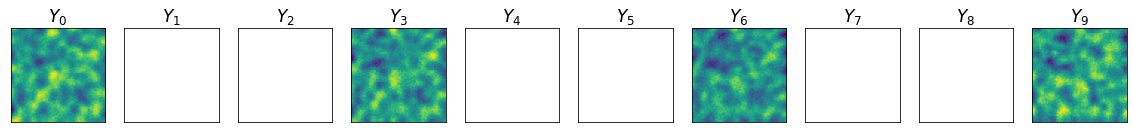

In [17]:
plt.figure(figsize=(20,4))

for t in range(Obs.shape[0]):
        
    plt.subplot(1,Obs.shape[0],t+1)
    plt.title('$Y_{'+str(t)+'}$',fontsize=17)
    if t%3==0:
        plt.imshow(Obs[t,0,:])
    else :
        plt.imshow(float('Nan')*Obs[t,0,:])
    plt.yticks([])
    plt.xticks([])

    #plt.subplot(2,T,T+t+1)
    #plot_w(Obs[t,1,:],Obs[t,2,:],quiver=True,title='w_'+str(t),q_scale=2.5)
    #plt.title('$w_{'+str(t)+'}$',fontsize=17)

plt.savefig('../figures/observations.pdf',bbox_inches='tight')
plt.show()

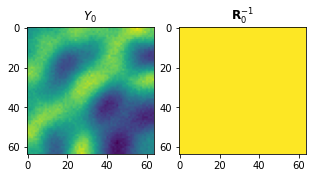

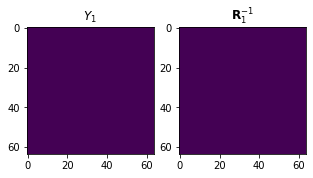

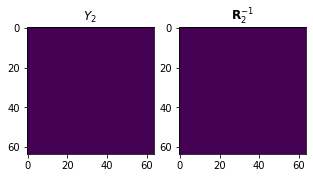

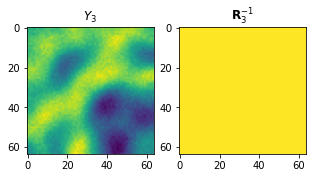

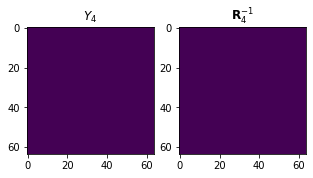

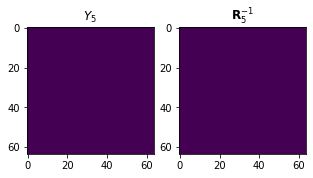

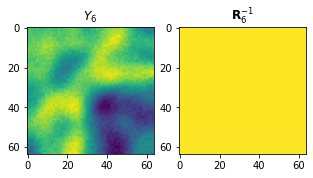

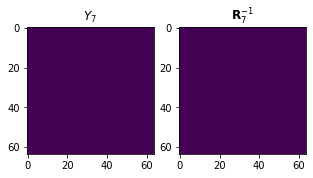

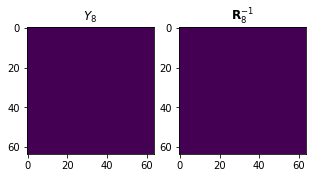

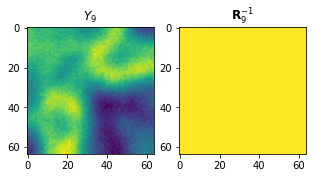

In [26]:
# Observations and associated variance
for t in range(10):
    
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(Obs[t,0,:,:])
    plt.title('$Y_'+str(t)+'$')
    plt.subplot(1,2,2)
    plt.imshow(Rm1[t,0,:,:],vmin=0,vmax=1)
    plt.title('$\mathbf{R}^{-1}_'+str(t)+'$')
    plt.show()

# 4D-Var

In [27]:
dynamics=SW(dx,dy)
Obs=torch.Tensor(Obs)
Rm1=torch.Tensor(Rm1)

n_iter : 74


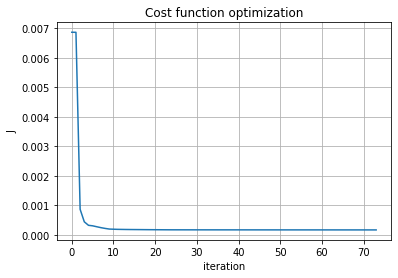

In [28]:
assim = strong_4DVar(dynamics=dynamics,
                     optimizer=optim.LBFGS([torch.zeros(0)],lr=0.75, max_iter=250))

assim.fit(Obs=Obs,Rm1=Rm1)
print('n_iter :',assim.n_iter)

# plot
plt.plot(assim.losses)
plt.grid()
plt.title('Cost function optimization')
plt.ylabel('J')
plt.xlabel('iteration')
plt.show()

ic_4dvar= assim.initial_condition
eta0_4dvar=ic_4dvar[0,:,:]
w0_4dvar=ic_4dvar[1:,:,:]

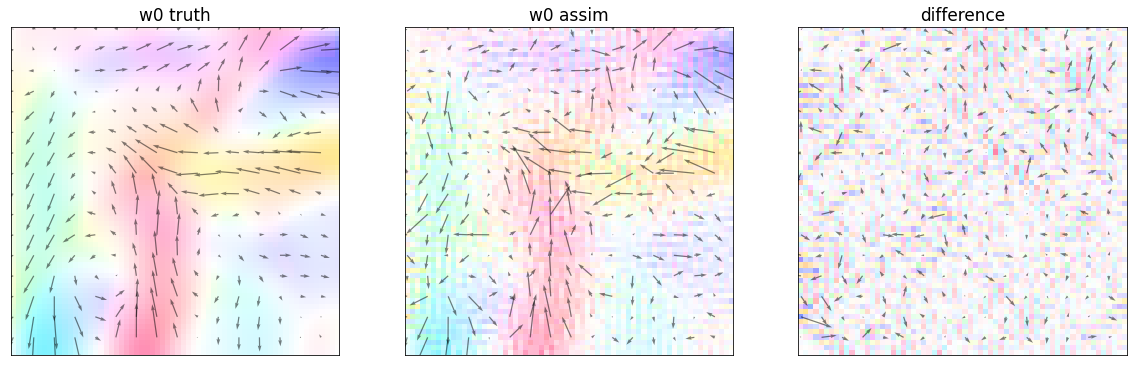

| Metric       |   Endpoint err. |   Angular err. (°) |   ||grad|| |   ||div|| |   ||lap|| |
|--------------+-----------------+--------------------+------------+-----------+-----------|
| 4D-Var       |       0.0720369 |            29.8845 |    10.2381 |   8.98169 | 17.3026   |
| Ground truth |       0         |             0      |     1.6495 |   1.61867 |  0.419867 |


In [29]:
plt.figure(figsize=(20,10))

plot_w_compare(w0_truth, w0_4dvar,
               quiver=True,q_scale=3,normalization = True)

print_w_compare(w0_truth, w0_4dvar)

# 4D-Var Thikonov regularization

n_iter : 48


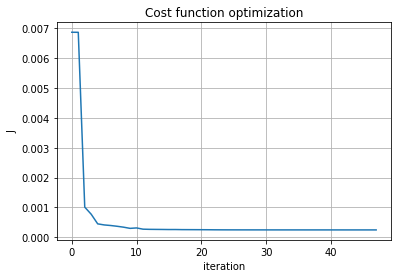

In [32]:
smoothreg= smooth_regul(alpha=5e3, beta=5e2,dx=dx,dy=dy)

assim = strong_4DVar(dynamics=dynamics, regul=smoothreg,
                     optimizer=optim.LBFGS([torch.zeros(0)],lr=0.75, max_iter=250))
assim.fit(Obs=Obs,Rm1=Rm1)
print('n_iter :',assim.n_iter)

# plot
plt.plot(assim.losses)
plt.grid()
plt.title('Cost function optimization')
plt.ylabel('J')
plt.xlabel('iteration')
plt.show()

ic_4dvar_reg= assim.initial_condition
eta0_4dvar_reg=ic_4dvar_reg[0,:,:]
w0_4dvar_reg=ic_4dvar_reg[1:,:,:]

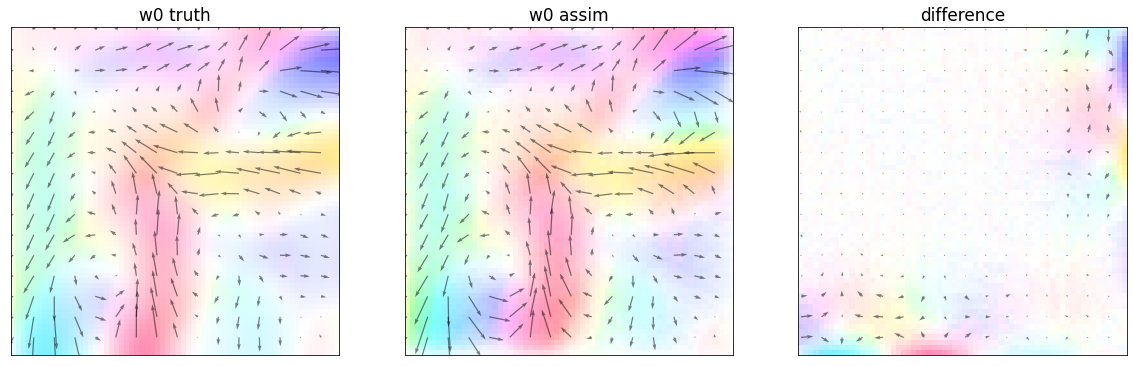

| Metric       |   Endpoint err. |   Angular err. (°) |   ||grad|| |   ||div|| |   ||lap|| |
|--------------+-----------------+--------------------+------------+-----------+-----------|
| 4D-Var       |       0.0284473 |            8.65001 |     2.1869 |   1.85504 |  1.91877  |
| Ground truth |       0         |            0       |     1.6495 |   1.61867 |  0.419867 |


In [33]:
plt.figure(figsize=(20,10))

plot_w_compare(w0_truth, w0_4dvar_reg,
               quiver=True,q_scale=3,normalization = True)

print_w_compare(w0_truth, w0_4dvar_reg)